In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
from datetime  import datetime
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE 
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

Check the data

In [2]:
df=pd.read_csv("../data/training_variants/training_variants")
print("The number of data points",df.shape[0])
print("The number of features",df.shape[1])
print("The features are :",df.columns.values)
df.head()

The number of data points 3321
The number of features 4
The features are : ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
df['Class'].nunique()

9

In [4]:
df['Variation'].nunique()

2996

There are 9 unique categories of output class
Gene - Location of the mutation
Variation - Type of variation

In [5]:
data_text =pd.read_csv("../data/training_text/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
stop_words = set(stopwords.words('english'))

def preprocess_text(full_text,index,column):
    if type(full_text) is not int:
        text = ""
        #replace special characters
        full_text=re.sub('[^\w+\n]', ' ', full_text)
        #replace multiple spaces with one space
        full_text=re.sub('[\s+]', ' ', full_text)
        # converting all the chars into lower-case.
        full_text = full_text.lower()
        
        for word in full_text.split():
            if word not in stop_words:
                text+=word+" "
        
        data_text[column][index]=text
                

In [7]:
start_time=datetime.now()
for index,row in data_text.iterrows():
    if type(row["TEXT"]) is str:
        preprocess_text(row["TEXT"],index,"TEXT")
    else:
        print(f"No text found at index {index}")

print(f"Time taken for the preprocessing - {datetime.now().second-start_time.second} seconds")

No text found at index 1109
No text found at index 1277
No text found at index 1407
No text found at index 1639
No text found at index 2755
Time taken for the preprocessing - 19 seconds


In [8]:
#Merge dataframes
result_data=pd.merge(df,data_text,on='ID',how='left')
result_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [9]:
result_data.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
TEXT         5
dtype: int64

In [10]:
result_data[result_data.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


There are some NAN text in the result dataframe so we will just fill with the text of Gene and Variation

In [11]:
result_data.loc[result_data['TEXT'].isnull(),'TEXT']=result_data['Gene']+' '+result_data['Variation']

In [12]:
result_data[result_data['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


<AxesSubplot:xlabel='Class', ylabel='count'>

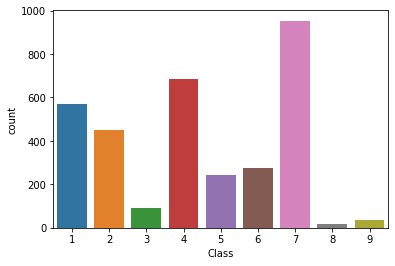

In [13]:
sns.countplot(data=result_data,x='Class')

The target class distribution is not uniform

In [14]:
y_true = result_data['Class'].values
result_data.Gene      = result_data.Gene.str.replace('\s+', '_')
result_data.Variation = result_data.Variation.str.replace('\s+', '_')

X_train, test_df, y_train, y_test = train_test_split(result_data, y_true, stratify=y_true, test_size=0.2)

train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [15]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [16]:
train_class_distribution = train_df['Class'].value_counts().sort_index(ascending=False)
test_class_distribution = test_df['Class'].value_counts().sort_index(ascending=False)
cv_class_distribution = cv_df['Class'].value_counts().sort_index(ascending=False)

In [17]:
train_class_distribution

9     24
8     12
7    609
6    176
5    155
4    439
3     57
2    289
1    363
Name: Class, dtype: int64

Number of data points in class 3 : 609 ( 28.672 %)
Number of data points in class 6 : 439 ( 20.669 %)
Number of data points in class 9 : 363 ( 17.09 %)
Number of data points in class 8 : 289 ( 13.606 %)
Number of data points in class 4 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 7 : 57 ( 2.684 %)
Number of data points in class 1 : 24 ( 1.13 %)
Number of data points in class 2 : 12 ( 0.565 %)


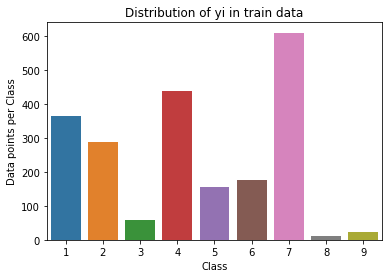

In [18]:
ax=sns.barplot(train_class_distribution.index,train_class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 3 : 191 ( 28.722 %)
Number of data points in class 6 : 137 ( 20.602 %)
Number of data points in class 9 : 114 ( 17.143 %)
Number of data points in class 8 : 91 ( 13.684 %)
Number of data points in class 4 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 7 : 18 ( 2.707 %)
Number of data points in class 1 : 7 ( 1.053 %)
Number of data points in class 2 : 4 ( 0.602 %)


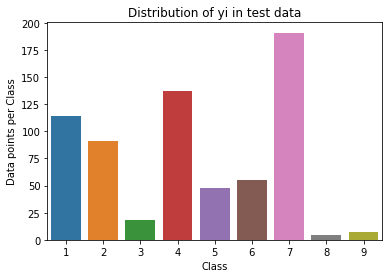

In [19]:
ax=sns.barplot(test_class_distribution.index,test_class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 3 : 153 ( 28.759 %)
Number of data points in class 6 : 110 ( 20.677 %)
Number of data points in class 9 : 91 ( 17.105 %)
Number of data points in class 8 : 72 ( 13.534 %)
Number of data points in class 4 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 7 : 14 ( 2.632 %)
Number of data points in class 1 : 6 ( 1.128 %)
Number of data points in class 2 : 3 ( 0.564 %)


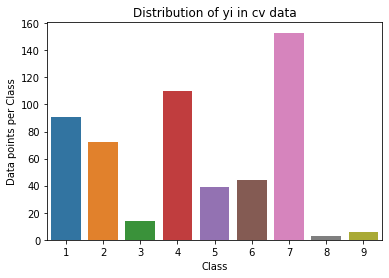

In [20]:
ax=sns.barplot(cv_class_distribution.index,cv_class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cv data')
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Create confusion , recall and precision matrix

In [21]:
def plot_matrices(y_test,y_pred):
    C=confusion_matrix(y_test,y_pred)
    A_recall=(((C.T)/(C.sum(axis=1))).T)
    B_precision=(C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B_precision, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A_recall, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [22]:
rand_probs = np.random.rand(1,9)
print(rand_probs)
print(sum(sum(rand_probs)))
val=(rand_probs/sum(sum(rand_probs)))
print(val)
print(val[0])

[[0.83187719 0.03067997 0.42104509 0.2521297  0.06863734 0.78970778
  0.87325772 0.76014837 0.51002479]]
4.537507953020033
[[0.1833335  0.00676141 0.09279214 0.05556568 0.01512666 0.17403998
  0.19245315 0.16752552 0.11240196]]
[0.1833335  0.00676141 0.09279214 0.05556568 0.01512666 0.17403998
 0.19245315 0.16752552 0.11240196]


665
Log loss on Cross Validation Data using Random Model 2.4980060177341694
Log loss on Test Data using Random Model 2.502615205626775
(665, 9)
(665,)
-------------------- Confusion matrix --------------------


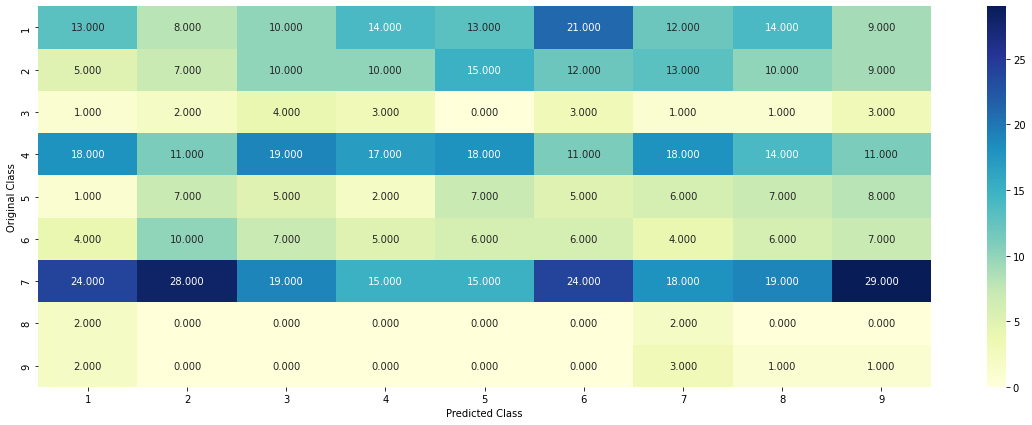

-------------------- Precision matrix (Columm Sum=1) --------------------


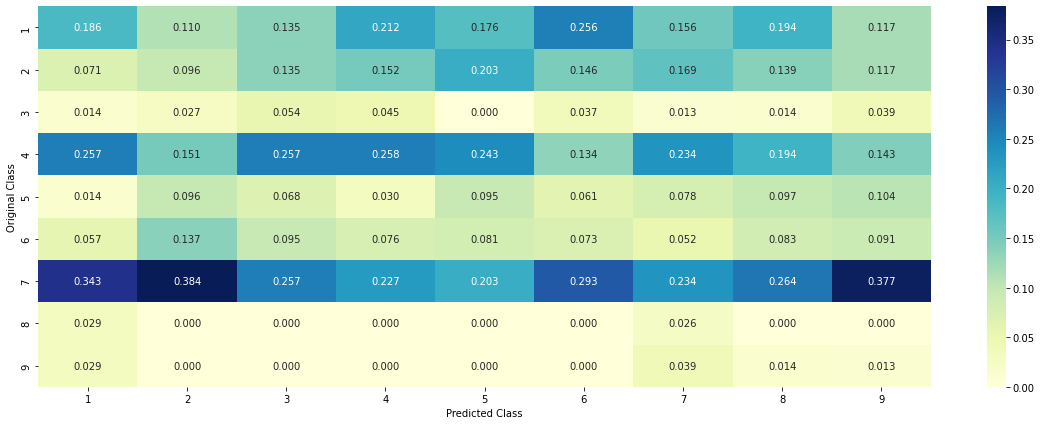

-------------------- Recall matrix (Row sum=1) --------------------


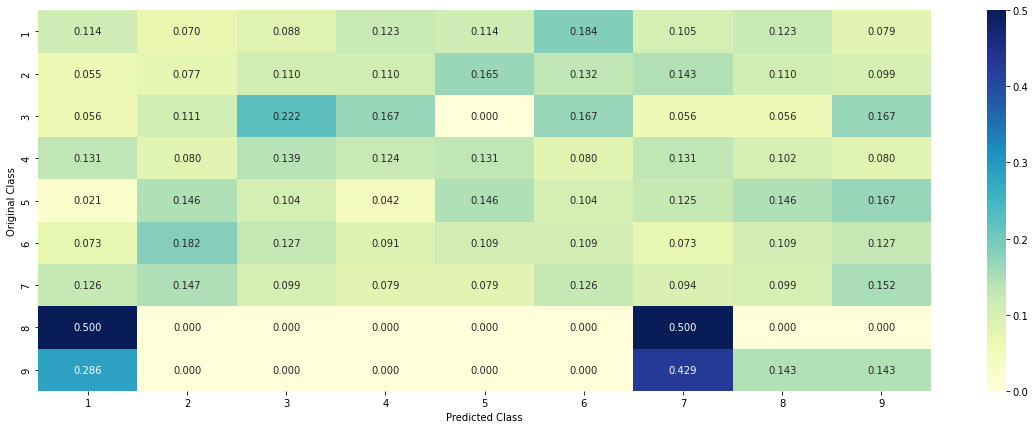

In [26]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]
print(test_data_len)
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

print(test_predicted_y.shape)
predicted_y =np.argmax(test_predicted_y, axis=1)
#print(predicted_y)
print(predicted_y.shape)
plot_matrices(y_test, predicted_y+1)

UNIVARIATE ANALYSIS

In [38]:
def get_gv_feature_dict(alpha,feature,df):
    value_count = df[feature].value_counts()
    gv_dict = dict()
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        vec = []
        for k in range(1,10):
            cls_cnt = df.loc[(df['Class']==k) & (df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data with the particular class
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

In [28]:
# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_feature_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = df[feature].value_counts()
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [29]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 227
BRCA1     180
TP53      105
EGFR      101
PTEN       83
BRCA2      77
BRAF       60
KIT        56
ERBB2      46
PIK3CA     41
ALK        41
Name: Gene, dtype: int64


In [34]:
unique_genes.values

array([180, 105, 101,  83,  77,  60,  56,  46,  41,  41,  38,  34,  33,
        33,  30,  29,  29,  28,  27,  26,  26,  24,  22,  20,  20,  19,
        18,  17,  17,  17,  16,  16,  16,  16,  15,  14,  14,  13,  13,
        13,  13,  12,  12,  12,  12,  12,  11,  11,  11,  11,  11,  10,
        10,  10,   9,   9,   9,   9,   9,   8,   8,   8,   8,   8,   8,
         8,   8,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
         6,   6,   6,   6,   6,   6,   6,   5,   5,   5,   5,   5,   5,
         5,   5,   5,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   

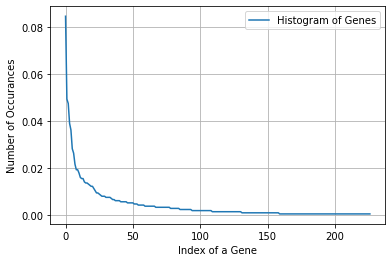

In [32]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.plot(h, label="Histogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

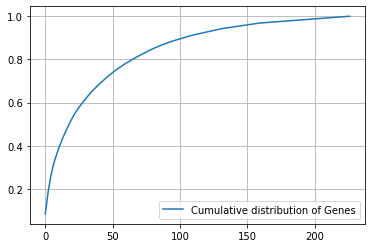

In [33]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [39]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [40]:
print("train_gene_feature_responseCoding is converted feature using response coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [41]:
print("test_gene_feature_responseCoding is converted feature using response coding method. The shape of gene feature:", test_gene_feature_responseCoding.shape)
print("cv_gene_feature_responseCoding is converted feature using response coding method. The shape of gene feature:", cv_gene_feature_responseCoding.shape)

test_gene_feature_responseCoding is converted feature using response coding method. The shape of gene feature: (665, 9)
cv_gene_feature_responseCoding is converted feature using response coding method. The shape of gene feature: (532, 9)


One Hot Encoding

In [42]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [43]:
train_df['Gene'].head()

1613       VHL
2805     BRCA2
50       PTPRT
901     PDGFRA
922     PDGFRA
Name: Gene, dtype: object

In [44]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid2',
 'asxl1',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'fubp1',
 'gata3',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'il7r',
 'inpp4b',
 'jak1',
 'jak2',


In [45]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 227)


For values of alpha =  1e-05 The log loss is: 1.2376976206144024
For values of alpha =  0.0001 The log loss is: 1.226976692733315
For values of alpha =  0.001 The log loss is: 1.257560224397421
For values of alpha =  0.01 The log loss is: 1.361521637371454
For values of alpha =  0.1 The log loss is: 1.4774030388160693
For values of alpha =  1 The log loss is: 1.518900315615195


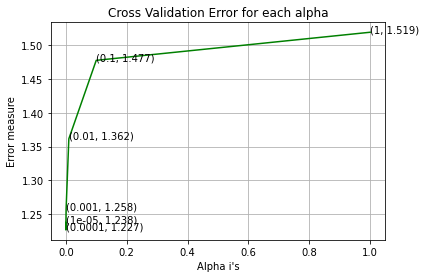

For values of best alpha =  0.0001 The train log loss is: 0.9767911128271629
For values of best alpha =  0.0001 The cross validation log loss is: 1.226976692733315
For values of best alpha =  0.0001 The test log loss is: 1.1895092906590434


In [46]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42) #LogisticRegression as loss is log
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid") # To get true probabilities
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [47]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  227  genes in train dataset?
Ans
1. In test data 636 out of 665 : 95.6390977443609
2. In cross validation data 512 out of  532 : 96.2406015037594
